# HR Analytics

### Try to predict which valuable employees will leave next 

** Why a company's best and most experienced employees leaving prematurely? **

Here the aim is to train a classifier that can help Human Resource department to predict which employee is higly probable of leaving the organization. This way HR dept. can try to retain people which are probable to leave the company.

>*Importing required libraries*

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
# Make plots larger
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn import cross_validation # used to test classifier
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics

import random
from datetime import datetime
random.seed(datetime.now())
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler # for scaling data 
from sklearn.metrics import roc_curve # ROC Curves
from sklearn.metrics import auc # Calculating AUC for ROC's!

from sklearn.naive_bayes import BernoulliNB,MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [2]:
hr_data_df = pd.read_csv('HR_comma_sep.csv')
hr_data_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Pre Processing and Exploratory Analysis of Data

In [3]:
hr_data_df.rename(columns={'sales': 'department'},inplace=True)

In [4]:
# Check for missing values in our data set
hr_data_df.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
department               False
salary                   False
dtype: bool

In [5]:
# Size of data
hr_data_df.shape

(14999, 10)

In [6]:
# Data type of our columns. 
hr_data_df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
department                object
salary                    object
dtype: object

In [7]:
leaving_rate_of_employees = hr_data_df.left.value_counts() / len(hr_data_df)
leaving_rate_of_employees

0    0.761917
1    0.238083
Name: left, dtype: float64

__ Looks like about 24% of employees left & 76% still working__ 

In [8]:
# Statistical Summary of the data
hr_data_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


> __Correlation Matrix__

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433
Work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000


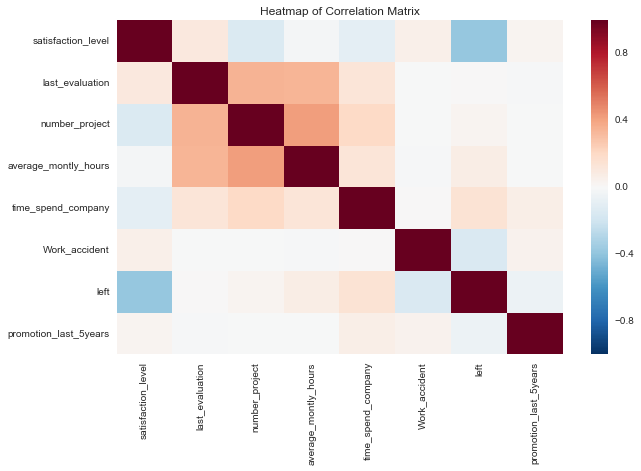

In [9]:
corr = hr_data_df.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
sns.plt.title('Heatmap of Correlation Matrix')
corr

>Here we can see no significant correlation **except in dependent variable left**. It means:
>* There is NO linear correlation between features,
>* BUT there can be non-linear correlation between features

### Now, Boxplot to find outliers

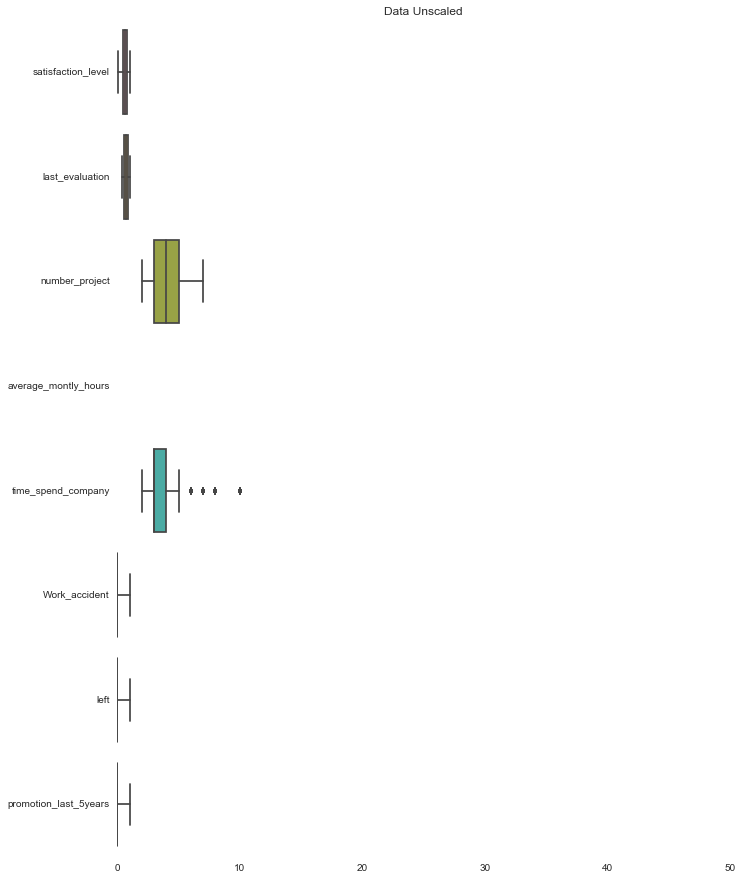

In [10]:
# To briefly see the data distribution and if there're outliers

f, ax = plt.subplots(figsize=(11, 15))

ax.set_axis_bgcolor('#FFFFFF')
plt.title("Data Unscaled")
ax.set(xlim=(-.05, 50.05))
ax = sns.boxplot(data = hr_data_df,orient = 'h')

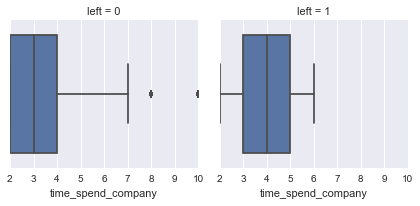

In [11]:
# Outliers do exist but looks like only for simply time_spend_company
qw = sns.FacetGrid(hr_data_df, col = 'left')
qw.map(sns.boxplot, 'time_spend_company')

In [12]:
# drop those observations
dropdata = hr_data_df[hr_data_df['time_spend_company'] >= 8]
hr_data_df.drop(dropdata.index, inplace = True)

> Most packages are not able to deal with string variables. Therefore we need to convert string to numeric

In [13]:
# First check what string values are
hr_data_df['department'].unique(),hr_data_df['salary'].unique()

(array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
        'IT', 'product_mng', 'marketing', 'RandD'], dtype=object),
 array(['low', 'medium', 'high'], dtype=object))

>Converting Above to Dummy Variables

In [14]:
X = hr_data_df.rename(columns={'department': 'department1'})
X_department = pd.get_dummies(X['department1'])
X_salary = pd.get_dummies( hr_data_df['salary'] )
Xd = pd.concat( [X, X_department, X_salary], axis=1 )
Xd = Xd.drop( ['department1','salary'], axis=1)
print( Xd.columns )
Xd.head()

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'IT', 'RandD', 'accounting', 'hr',
       'management', 'marketing', 'product_mng', 'sales', 'support',
       'technical', 'high', 'low', 'medium'],
      dtype='object')


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,IT,RandD,...,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
0,0.38,0.53,2,157,3,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.80,0.86,5,262,6,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.11,0.88,7,272,4,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.72,0.87,5,223,5,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.37,0.52,2,159,3,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


> Separating our Dependent variable __left__

In [15]:
X = Xd.drop('left', axis=1)
y = Xd['left']
print( X.shape )
print( y.shape )

(14623, 20)
(14623,)


> Function to Divide data into a training and a testing set (30% testing)

In [16]:
def split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .3, random_state=0)
    return X_train, X_test, y_train, y_test

> Function to Scale Data

In [17]:
def scaled_df(df):
    scaled = pd.DataFrame()
    for item in df:
        if item in df.select_dtypes(include=[np.float]):
            scaled[item] = ((df[item] - df[item].min()) / 
            (df[item].max() - df[item].min()))
        else: 
            scaled[item] = df[item]
    return scaled

> Function to normalize data 

In [18]:
def normalize(df):
    return (df - df.mean()) / (df.max() - df.min())

# Part A - kNN Classifier

__Running for Unscaled Data__

In [19]:
X_train, X_test, y_train, y_test = split_data(X,y)
knn_k = []
for i in range(0,20):  # try up to k=20
    if (i % 2 != 0): # Use only odd k 
        knn_k.append(i)

cross_vals = []
for k in knn_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,
                             X_train, 
                             y_train, 
                             cv = 10, 
                             scoring='accuracy')
    cross_vals.append(scores.mean())

MSE = [1 - x for x in cross_vals]
optimal_k = knn_k[MSE.index(min(MSE))]
print("Optimal K is {0}".format(optimal_k))

Optimal K is 1


In [20]:
# setting kNN classifier
knn = KNeighborsClassifier(n_neighbors=1)

#dividing data to have a training and a testing set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .4, random_state=0)

# kNN cross validation
Kfold = KFold(len(X_train), n_folds=5, shuffle=False)
print("KfoldCrossVal mean score using kNN is %s" %cross_val_score(knn,X_train,y_train,cv=10,scoring='accuracy').mean())

# kNN metrics
kNNm = knn.fit(X_train, y_train)

y_pred = kNNm.predict(X_test)
print("Accuracy score using kNN is %s" %metrics.accuracy_score(y_test, y_pred))

KfoldCrossVal mean score using kNN is 0.945683056656
Accuracy score using kNN is 0.951219512195


__Running for scaled data__

In [21]:
X_train, X_test, y_train, y_test = split_data(scaled_df(X),y)
knn_k = []
for i in range(0,20):  # try up to k=20
    if (i % 2 != 0): # Use only odd k 
        knn_k.append(i)

cross_vals = []
for k in knn_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,
                             X_train, 
                             y_train, 
                             cv = 10, 
                             scoring='accuracy')
    cross_vals.append(scores.mean())

MSE = [1 - x for x in cross_vals]
optimal_k = knn_k[MSE.index(min(MSE))]
print("Optimal K is {0}".format(optimal_k))

Optimal K is 1


In [22]:
# setting kNN classifier
knn = KNeighborsClassifier(n_neighbors=1)

#dividing data to have a training and a testing set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .4, random_state=0)

# kNN cross validation
Kfold = KFold(len(X_train), n_folds=5, shuffle=False)
print("KfoldCrossVal mean score using kNN is %s" %cross_val_score(knn,X_train,y_train,cv=10,scoring='accuracy').mean())

# kNN metrics
kNNm = knn.fit(X_train, y_train)

y_pred = kNNm.predict(X_test)
print("Accuracy score using kNN is %s" %metrics.accuracy_score(y_test, y_pred))

KfoldCrossVal mean score using kNN is 0.945683152116
Accuracy score using kNN is 0.949851834967


__Running for Normalized Data__

In [23]:
X_train, X_test, y_train, y_test = split_data(normalize(X),y)
knn_k = []
for i in range(0,20):  # try up to k=20
    if (i % 2 != 0): # Use only odd k 
        knn_k.append(i)

cross_vals = []
for k in knn_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,
                             X_train, 
                             y_train, 
                             cv = 10, 
                             scoring='accuracy')
    cross_vals.append(scores.mean())

MSE = [1 - x for x in cross_vals]
optimal_k = knn_k[MSE.index(min(MSE))]
print("Optimal K is {0}".format(optimal_k))

Optimal K is 1


In [24]:
# setting kNN classifier
knn = KNeighborsClassifier(n_neighbors=1)

#dividing data to have a training and a testing set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .4, random_state=0)

# kNN cross validation
Kfold = KFold(len(X_train), n_folds=5, shuffle=False)
print("KfoldCrossVal mean score using kNN is %s" %cross_val_score(knn,X_train,y_train,cv=10,scoring='accuracy').mean())

# kNN metrics
kNNm = knn.fit(X_train, y_train)

y_pred = kNNm.predict(X_test)
print("Accuracy score using kNN is %s" %metrics.accuracy_score(y_test, y_pred))

KfoldCrossVal mean score using kNN is 0.962291117558
Accuracy score using kNN is 0.959197629359


### Summary of Part A

**kNN performance varied as follows:**
>As __k__ was incremented, accuracy decreased

>For different types of data:
>> Results were best for __Normalized data__
>>#Normalised Data : 0.95919762
>>#Unscaled Data : 0.9512195
>>#Scaled Data : 0.94985183

>__Function to run further models__

>It is easy to run different models in this fashion

In [25]:
def run_model( X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .3, random_state=0)

    Kfold = KFold(len(X), n_folds=5, shuffle=False)
    KfoldCrossVal_mean_score =cross_val_score(model,X,y,cv=10).mean()
    
    sm = model.fit(X_train, y_train)
    y_pred = sm.predict(X_test)
    Accuracy_score = metrics.accuracy_score(y_test, y_pred)
    return KfoldCrossVal_mean_score,Accuracy_score

# PART B- Decision Trees & Random Forest

__For Unscaled Data__

In [26]:
KfoldCrossVal_mean_score,Accuracy_score = run_model( X, y, DecisionTreeClassifier() )
print("For DecisionTree Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For DecisionTree Classifier
KfoldCrossVal mean score is 0.982424658295
Accuracy score is 0.975609756098


In [27]:
KfoldCrossVal_mean_score,Accuracy_score = run_model( X, y, RandomForestClassifier() )
print("For RandomForest Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For RandomForest Classifier
KfoldCrossVal mean score is 0.990561436292
Accuracy score is 0.986779120128


__For Scaled Data__

In [28]:
KfoldCrossVal_mean_score,Accuracy_score = run_model( scaled_df(X), y, DecisionTreeClassifier() )
print("For DecisionTree Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For DecisionTree Classifier
KfoldCrossVal mean score is 0.982287392372
Accuracy score is 0.974697971279


In [29]:
KfoldCrossVal_mean_score,Accuracy_score = run_model( scaled_df(X), y, RandomForestClassifier() )
print("For RandomForest Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For RandomForest Classifier
KfoldCrossVal mean score is 0.990082313044
Accuracy score is 0.986551173923


__For Normalized Data__

In [30]:
KfoldCrossVal_mean_score,Accuracy_score = run_model( normalize(X), y, DecisionTreeClassifier() )
print("For DecisionTree Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For DecisionTree Classifier
KfoldCrossVal mean score is 0.981398620005
Accuracy score is 0.974014132665


In [31]:
KfoldCrossVal_mean_score,Accuracy_score = run_model( normalize(X), y, RandomForestClassifier() )
print("For RandomForest Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For RandomForest Classifier
KfoldCrossVal mean score is 0.990492756577
Accuracy score is 0.985867335309


### Summary of Part B

**Decision Tree performance varied as follows:**
>For different types of data, Results were best for __Normalized data__
>>#Normalised Data : 0.97583770
>>#Unscaled Data : 0.97515386
>>#Scaled Data : 0.975609756

**Random Forest performance varied as follows:**
>For different types of data, Results were best for __Scaled data__
>>#Normalised Data : 0.98609528
>>#Unscaled Data : 0.98677912
>>#Scaled Data : 0.98700706

### Overall Random Forest performed better than Decision Tree

# PART C - Naive Bayes

__For Unscaled Data__

In [32]:
KfoldCrossVal_mean_score,Accuracy_score = run_model( X, y, BernoulliNB() )
print("For BernoulliNB Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For BernoulliNB Classifier
KfoldCrossVal mean score is 0.755795697003
Accuracy score is 0.765443355368


In [33]:
KfoldCrossVal_mean_score,Accuracy_score = run_model( X, y, MultinomialNB() )
print("For MultinomialNB Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For MultinomialNB Classifier
KfoldCrossVal mean score is 0.755316994275
Accuracy score is 0.765443355368


In [34]:
KfoldCrossVal_mean_score,Accuracy_score = run_model( X, y, GaussianNB() )
print("For GaussianNB Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For GaussianNB Classifier
KfoldCrossVal mean score is 0.692340490465
Accuracy score is 0.670845680419


__For Scaled Data__

In [35]:
KfoldCrossVal_mean_score,Accuracy_score = run_model( scaled_df(X), y, BernoulliNB() )
print("For BernoulliNB Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For BernoulliNB Classifier
KfoldCrossVal mean score is 0.769130879846
Accuracy score is 0.777752450422


In [36]:
KfoldCrossVal_mean_score,Accuracy_score = run_model( scaled_df(X), y, MultinomialNB() )
print("For MultinomialNB Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For MultinomialNB Classifier
KfoldCrossVal mean score is 0.754291282872
Accuracy score is 0.764987462959


In [37]:
KfoldCrossVal_mean_score,Accuracy_score = run_model( scaled_df(X), y, GaussianNB() )
print("For GaussianNB Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For GaussianNB Classifier
KfoldCrossVal mean score is 0.692340490465
Accuracy score is 0.670845680419


### Summary of Part C

**Naive Bayes performance varied as follows:**
>For different types of data, Results were best for __Scaled data__
>>#Unscaled Data : 0.76544335
>>#Scaled Data : 0.77775245

Out of **Bernoulli, Multinomial ,Gaussian Naive Bayes** performance is varied as follows:
>For different types of data, Results were best for __Bernoulli data__
>>#Bernoulli Data : 0.77775245
>>#Multinomial Data : 0.76498746
>>#Gaussian Data : 0.67084568

### Overall Scaled data for Bernoulli NB performed better than All

# PART D - Support Vector Machines

__For Unscaled Data__

In [38]:
svc = SVC().fit(X, y)
KfoldCrossVal_mean_score,Accuracy_score = run_model( X, y, svc )
print("For RBF Kernel SVM Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For RBF Kernel SVM Classifier
KfoldCrossVal mean score is 0.949257092892
Accuracy score is 0.946660588101


__For Scaled Data__

In [39]:
svc = SVC().fit(scaled_df(X), y)
KfoldCrossVal_mean_score,Accuracy_score = run_model( X, y, svc )
print("For RBF Kernel SVM Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For RBF Kernel SVM Classifier
KfoldCrossVal mean score is 0.949257092892
Accuracy score is 0.946660588101


__For Normalized Data__

In [40]:
svc = SVC().fit(normalize(X), y)
KfoldCrossVal_mean_score,Accuracy_score = run_model( X, y, svc )
print("For RBF Kernel SVM Classifier")
print("KfoldCrossVal mean score is %s" %KfoldCrossVal_mean_score)
print("Accuracy score is %s" %Accuracy_score)

For RBF Kernel SVM Classifier
KfoldCrossVal mean score is 0.949257092892
Accuracy score is 0.946660588101


### Summary of Part D

**SVM performance varied as follows:**
>For different types of data, Results were __same for all types of data__
>>#Unscaled Data : 0.946660588101
>>#Scaled Data : 0.946660588101
>>#Normalized Data : 0.946660588101

For all kernels other than RBF (default kernel), runtime of SVM very large.

### SVM determines decision function which comes out as same, hence no difference produced by scaling or normalizing data.

----------------------------------

----------------------------------

# PART E - Comparison

## Random Forest Classification algorithm has the highest accuracy.

### Accuracy over 98.6%

Majority of my Data contains data which is not continuous, like:
* Satisfaction Level
* Years Worked
* Promotion
* Number of Projects,etc.

Such kind of data makes it very intuitive for trees to make decisions based on their __YES__ or __NO__ value.
Hence Decision trees were giving accuracy of __97.5%__

The random forest is an Ensemble Method, that combines decision trees. 
Ensembles are a divide-and-conquer approach used to improve performance. The main principle behind ensemble methods is that a group of “weak learners” can come together to form a “strong learner".

Thus, in ensemble terms, the trees are weak learners and the random forest is a strong learner.

Hence accuracy of Random forest is highest and that's why __best model__ for my data set.